In [1]:
import numpy as np
import gym
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn import preprocessing
import matplotlib.pyplot as plt
from torch.distributions import Categorical
from torch.distributions import Normal
import torch.nn.functional as F
import optuna
import optuna.visualization as vis

In [2]:
import sys
sys.modules[__name__]

<module '__main__'>

# Define environment

In [3]:
class CSTR:
    def __init__(self, V, q, c0, k0, Ea, R, deltaH):
        self.V = V
        self.q = q
        self.c0 = c0
        self.k0 = k0
        self.Ea = Ea
        self.R = R
        self.deltaH = deltaH
        
        self.c = c0
        self.T = 300.0 # initial temperature
        
#         # Define action space
#         self.action_space = spaces.Box(low=0, high=np.inf, shape=(1,))

#         # Define observation space
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(3,))
     
    
    def step(self, u):
        # u is the input flow rate
        Fa = u
        F = self.q * self.V
        ca, cb, cc = self.c
        
        # Compute the reaction rate constant
        k = self.k0 * np.exp(-self.Ea / (self.R * self.T))
        
        # Compute the reaction rate
        r = k * ca * cb
        
        # Compute the rate of change of the concentrations
        dca_dt = (Fa * self.c0[0] - F * ca - self.V * r) / (self.V * self.q)
        dcb_dt = (Fa * self.c0[1] - F * cb + self.V * r) / (self.V * self.q)
        dcc_dt = (-Fa * cc + F * (self.c0[2] - cc) - self.V * r) / (self.V * self.q)
        
        # Update the concentrations
        self.c += np.array([dca_dt, dcb_dt, dcc_dt]) * 0.1
        
        # Compute the new temperature
        dT_dt = (self.deltaH / (self.R * self.V * self.q)) * r
        self.T += dT_dt * 0.1
        
        # Compute the output
        y = self.c[2]
        
        return y

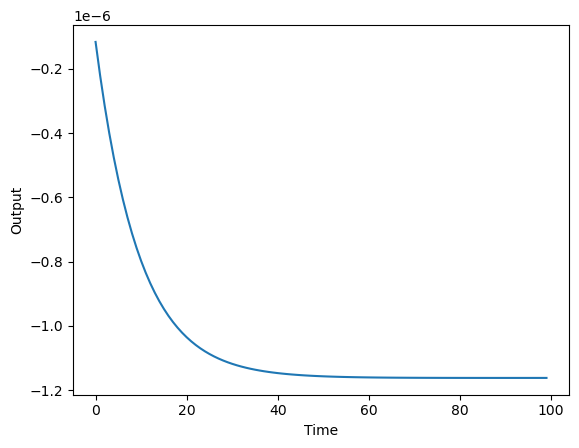

In [4]:
# Define the input flow rate profile
u = np.ones((100,)) * 10.0

# Define the model parameters
V = 10.0
q = 1.0
c0 = np.array([1.0, 2.0, 0.0])
k0 = 1e9
Ea = 87500.0
R = 8.314
deltaH = -4.2e4

# Create an instance of the CSTR class
cstr = CSTR(V, q, c0, k0, Ea, R, deltaH)

# Run the simulation
y = np.zeros((100,))
for i in range(100):
    y[i] = cstr.step(u[i])
    
# Plot the output
plt.plot(y)
plt.xlabel('Time')
plt.ylabel('Output')
plt.show()

# Define Gym interface (OpenAI)

In [5]:
class CSTREnv(gym.Env):
    def __init__(self, V=10.0, q=1.0, c0=[1.0, 2.0, 0.0], k0=1.0e9, Ea=87500.0, R=8.314, deltaH=--4.2e4):
        super(CSTREnv, self).__init__()
        
        self.cstr = CSTR(V, q, c0, k0, Ea, R, deltaH)
        
        self.action_space = gym.spaces.Box(low=0.0, high=1000.0, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=0.0, high=np.inf, shape=(3,), dtype=np.float32)
        
        self.done = False
        
    def reset(self):
        self.done = False
        return self.cstr.c

    
    def step(self, action):
        u = action[0]
        y = self.cstr.step(u)
        obs = self.cstr.c

        # Compute the reward
        reward = -np.abs(y - 0.5) - 0.01 * np.abs(u)
        if np.abs(y - 0.5) < 0.1:
            reward += 1.0
            self.done = True

        return obs, reward, self.done, {}
        
    
# Set the environment ID
try:
    gym.envs.register(
      id='SimulateCSTR-v1',
      entry_point='__main__:CSTREnv',
      max_episode_steps=1000
    )
except:
    pass

Reward defined as followed:

En este caso, el reward se utiliza para evaluar qué tan cerca está el sistema de alcanzar la concentración objetivo del reactor de CSTR. El objetivo del agente es maximizar la recompensa total a través de la toma de decisiones que le permitan acercar la concentración del sistema al valor deseado.

El reward se calcula a partir de dos términos. El primer término está relacionado con qué tan cerca está la concentración actual del sistema del valor objetivo (0.5). Este término es negativo y disminuye cuando la concentración se aleja del valor deseado. El segundo término está relacionado con qué tan grande es la señal de control u que el agente está aplicando. Este término también es negativo y disminuye a medida que la señal de control es mayor.

Si el valor absoluto de la diferencia entre la concentración actual del sistema y la concentración objetivo es menor que 0.1, se agrega un término positivo a la recompensa que aumenta el valor de la recompensa en 1.0. Además, el episodio se considera "terminado" estableciendo la variable self.done en True.

# Actor-critic algorithm

In [6]:
# class Actor(nn.Module):
#     def __init__(self, state_size, action_size):
#         super(Actor, self).__init__()
#         self.fc1 = nn.Linear(state_size, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, action_size)
        
#     def forward(self, state):
#         x = torch.relu(self.fc1(state))
#         x = torch.relu(self.fc2(x))
#         x = torch.tanh(self.fc3(x))
#         return x

# class Actor(nn.Module):
#     def __init__(self, state_size, action_size):
#         super(Actor, self).__init__()
#         self.fc1 = nn.Linear(state_size, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, action_size)
#         self.fc4 = nn.Linear(32, action_size)
        
#     def forward(self, state):
#         x = torch.relu(self.fc1(state))
#         x = torch.relu(self.fc2(x))
#         mean = torch.tanh(self.fc3(x))
#         std = F.softplus(self.fc4(x))
#         return mean, std

# class Critic(nn.Module):
#     def __init__(self, state_size):
#         super(Critic, self).__init__()
#         self.fc1 = nn.Linear(state_size, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 1)
        
#     def forward(self, state):
#         x = torch.relu(self.fc1(state))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

class Actor(nn.Module):
    def __init__(self, state_size, action_size, layers, hidden_sizes):
        super(Actor, self).__init__()
        self.hidden_layers = nn.ModuleList()
        input_size = state_size
        for i in range(layers):
            self.hidden_layers.append(nn.Linear(input_size, hidden_sizes))
            input_size = hidden_sizes
        self.output_layer = nn.Linear(input_size, action_size)
        
    def forward(self, state):
        x = state
        for hidden_layer in self.hidden_layers:
            x = torch.relu(hidden_layer(x))
        mean = torch.tanh(self.output_layer(x))
        std = F.softplus(self.output_layer(x))
        return mean, std

class Critic(nn.Module):
    def __init__(self, state_size, layers, hidden_sizes):
        super(Critic, self).__init__()
        self.hidden_layers = nn.ModuleList()
        input_size = state_size
        for i in range(layers):
            self.hidden_layers.append(nn.Linear(input_size, hidden_sizes))
            input_size = hidden_sizes
        self.output_layer = nn.Linear(input_size, 1)
        
    def forward(self, state):
        x = state
        for hidden_layer in self.hidden_layers:
            x = torch.relu(hidden_layer(x))
        value = self.output_layer(x)
        return value

In [7]:
class A2C:
    def __init__(self, env, lr_actor=1e-5, lr_critic=1e-5, gamma=0.99,
                 actor_hidden_sizes=64, critic_hidden_sizes=64, 
                actor_layers=2, critic_layers=2):
        self.env = env
        self.gamma = gamma
        self.actor = Actor(env.observation_space.shape[0], env.action_space.shape[0],
                           actor_layers, actor_hidden_sizes).float()
        self.critic = Critic(env.observation_space.shape[0], critic_layers, critic_hidden_sizes).float()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
        
    def train(self, n_episodes, max_timesteps):
        actor_losses = []
        critic_losses = []
        episode_rewards = []

        for i_episode in range(n_episodes):
            state = self.env.reset()
            total_reward = 0

            for t in range(max_timesteps):
                # Sample action from the actor
                mean, std = self.actor(torch.tensor(state).float())
                dist = Normal(mean, std)
                action = dist.sample().numpy()
                log_prob = dist.log_prob(torch.tensor(action)).sum()

                # Take a step in the environment
                next_state, reward, done, _ = self.env.step(action)
                total_reward += reward

                # Compute the TD error
                value = self.critic(torch.tensor(state).float())
                next_value = self.critic(torch.tensor(next_state).float())
                td_error = reward + self.gamma * next_value.detach() * (1 - int(done)) - value

                # Update the critic
                self.critic_optimizer.zero_grad()
                loss_critic = td_error.pow(2).mean()
                loss_critic.backward()
                self.critic_optimizer.step()

                # Update the actor
                self.actor_optimizer.zero_grad()
                loss_actor = -(log_prob * td_error.detach()).mean()
                loss_actor.backward()
                self.actor_optimizer.step()

                state = next_state

                if done:
                    break

            # Store the losses and total reward
            actor_losses.append(loss_actor.item())
            critic_losses.append(loss_critic.item())
            episode_rewards.append(total_reward)

            # Print statistics
            print(f"Episode {i_episode + 1}/{n_episodes}: reward={total_reward:.2f}")

        return actor_losses, critic_losses, episode_rewards

In [8]:
env = gym.make("SimulateCSTR-v1")
agent = A2C(env)
actor_losses, critic_losses, episode_rewards = agent.train(n_episodes=20, max_timesteps=1000)

Episode 1/20: reward=-505.86
Episode 2/20: reward=-505.90
Episode 3/20: reward=-506.21
Episode 4/20: reward=-506.21
Episode 5/20: reward=-505.97
Episode 6/20: reward=-506.03
Episode 7/20: reward=-505.91
Episode 8/20: reward=-505.88
Episode 9/20: reward=-505.86
Episode 10/20: reward=-506.22
Episode 11/20: reward=-505.87
Episode 12/20: reward=-505.80
Episode 13/20: reward=-505.99
Episode 14/20: reward=-505.96
Episode 15/20: reward=-505.89
Episode 16/20: reward=-506.07
Episode 17/20: reward=-505.76
Episode 18/20: reward=-505.94
Episode 19/20: reward=-505.91
Episode 20/20: reward=-505.75


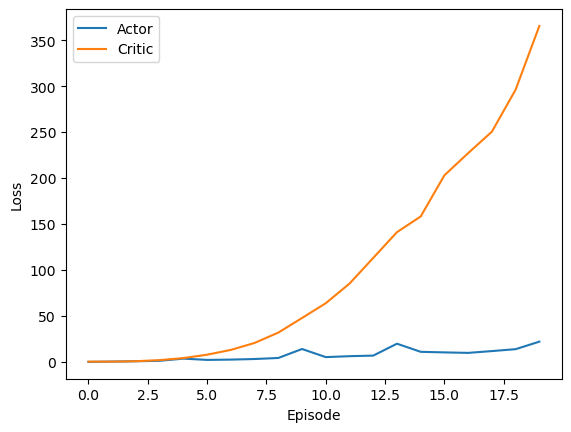

In [9]:
plt.plot(actor_losses, label="Actor")
plt.plot(critic_losses, label="Critic")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

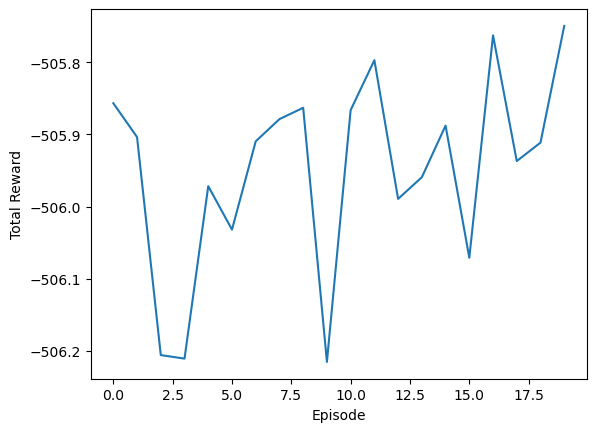

In [10]:
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

In [11]:
actor_losses

[-0.2639554440975189,
 0.12665025889873505,
 0.47382500767707825,
 0.9574459195137024,
 3.3271210193634033,
 1.9276278018951416,
 2.2549498081207275,
 2.901587963104248,
 4.043478965759277,
 13.80214786529541,
 4.973977088928223,
 5.993862152099609,
 6.610389709472656,
 19.58164405822754,
 10.737278938293457,
 10.114469528198242,
 9.575770378112793,
 11.543254852294922,
 13.626914978027344,
 21.821054458618164]

In [12]:
critic_losses

[0.05743064358830452,
 0.034260693937540054,
 0.49645406007766724,
 1.6929523944854736,
 3.913839101791382,
 7.611852645874023,
 12.817082405090332,
 20.400392532348633,
 31.671934127807617,
 47.56639862060547,
 63.669334411621094,
 85.03689575195312,
 112.98875427246094,
 141.0542755126953,
 158.1487579345703,
 202.9972686767578,
 227.11627197265625,
 250.45172119140625,
 296.2073059082031,
 365.6441650390625]

In [13]:
episode_rewards

[-505.8567894317665,
 -505.9036925195162,
 -506.20556772571706,
 -506.2104405358836,
 -505.9716190651304,
 -506.0318150777031,
 -505.9095533393178,
 -505.87878982422365,
 -505.86307862987985,
 -506.21502740038454,
 -505.86632439804544,
 -505.7971808571966,
 -505.9892453932308,
 -505.95925108400826,
 -505.8877961542362,
 -506.07071737970426,
 -505.76279019716236,
 -505.9368897224295,
 -505.9113396325148,
 -505.7497206469546]

# Hyperparameter optimization

In [16]:
def objective(trial):
    # Define the hyperparameters to optimize
    lr_actor = trial.suggest_float("lr_actor", 1e-4, 1e-3)
    lr_critic = trial.suggest_float("lr_critic", 1e-4, 1e-3)
    gamma = trial.suggest_float("gamma", 0.95, 0.999)
    hidden_size_actor = trial.suggest_int("hidden_size_actor", 32, 96)
    hidden_size_critic = trial.suggest_int("hidden_size_critic", 32, 96)
    actor_layers = trial.suggest_int("actor_layers", 3, 7)
    critic_layers = trial.suggest_int("critic_layers", 3, 7)
    max_tim = trial.suggest_int("max_tim", 200, 5000)
    
    # Create the environment
    env = gym.make("SimulateCSTR-v1")
    
    # Create the A2C agent with the current hyperparameters
    agent = A2C(env, lr_actor=lr_actor, lr_critic=lr_critic, gamma=gamma, actor_hidden_sizes=hidden_size_actor,
               critic_hidden_sizes=hidden_size_critic, actor_layers=actor_layers, critic_layers=critic_layers)
    
    # Train the agent and get the total rewards at each episode
    _, _, episode_rewards = agent.train(n_episodes=5, max_timesteps=max_tim)
    
    # Compute the average total reward over all episodes
    avg_total_reward = sum(episode_rewards) / len(episode_rewards)
    
    # Return the average total reward as the objective to minimize
    return -avg_total_reward

# Create an Optuna study and optimize the hyperparameters
study = optuna.create_study()
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print(study.best_params)

[I 2023-03-27 13:17:33,022] A new study created in memory with name: no-name-9c196a2b-10b0-4e6a-9386-e140743a4d8f


Episode 1/5: reward=-505.61
Episode 2/5: reward=-504.80
Episode 3/5: reward=-507.21
Episode 4/5: reward=-505.48


[I 2023-03-27 13:18:04,585] Trial 0 finished with value: 505.65267872897664 and parameters: {'lr_actor': 0.00047164381507713924, 'lr_critic': 0.00035026418122850175, 'gamma': 0.9947012598425967, 'hidden_size_actor': 56, 'hidden_size_critic': 96, 'actor_layers': 6, 'critic_layers': 7, 'max_tim': 2577}. Best is trial 0 with value: 505.65267872897664.


Episode 5/5: reward=-505.16
Episode 1/5: reward=-505.21
Episode 2/5: reward=-505.59
Episode 3/5: reward=-505.32
Episode 4/5: reward=-505.39


[I 2023-03-27 13:18:31,104] Trial 1 finished with value: 505.4785539211518 and parameters: {'lr_actor': 0.000857159201111591, 'lr_critic': 0.000506844514857409, 'gamma': 0.9774766308786551, 'hidden_size_actor': 45, 'hidden_size_critic': 76, 'actor_layers': 7, 'critic_layers': 6, 'max_tim': 4629}. Best is trial 1 with value: 505.4785539211518.


Episode 5/5: reward=-505.89
Episode 1/5: reward=-505.45
Episode 2/5: reward=-508.27
Episode 3/5: reward=-515.53
Episode 4/5: reward=-507.87


[I 2023-03-27 13:18:57,561] Trial 2 finished with value: 509.19177272487497 and parameters: {'lr_actor': 0.0008945456269720483, 'lr_critic': 0.0007082345104553595, 'gamma': 0.9879667996844652, 'hidden_size_actor': 79, 'hidden_size_critic': 43, 'actor_layers': 7, 'critic_layers': 7, 'max_tim': 3922}. Best is trial 1 with value: 505.4785539211518.


Episode 5/5: reward=-508.84
Episode 1/5: reward=-505.88
Episode 2/5: reward=-505.54
Episode 3/5: reward=-505.43
Episode 4/5: reward=-504.98


[I 2023-03-27 13:19:24,661] Trial 3 finished with value: 505.5916514230711 and parameters: {'lr_actor': 0.00028541050204741405, 'lr_critic': 0.000967821191279092, 'gamma': 0.9920184335201941, 'hidden_size_actor': 72, 'hidden_size_critic': 73, 'actor_layers': 6, 'critic_layers': 7, 'max_tim': 1501}. Best is trial 1 with value: 505.4785539211518.


Episode 5/5: reward=-506.13
Episode 1/5: reward=-325.01
Episode 2/5: reward=-324.81
Episode 3/5: reward=-324.97
Episode 4/5: reward=-324.84


[I 2023-03-27 13:19:35,752] Trial 4 finished with value: 324.8463800058114 and parameters: {'lr_actor': 0.00027992883218321034, 'lr_critic': 0.000574425305732212, 'gamma': 0.9868417055789047, 'hidden_size_actor': 60, 'hidden_size_critic': 91, 'actor_layers': 5, 'critic_layers': 3, 'max_tim': 643}. Best is trial 4 with value: 324.8463800058114.


Episode 5/5: reward=-324.60
Episode 1/5: reward=-334.49
Episode 2/5: reward=-334.46
Episode 3/5: reward=-334.43
Episode 4/5: reward=-334.24


[I 2023-03-27 13:19:46,332] Trial 5 finished with value: 334.3872754791595 and parameters: {'lr_actor': 0.00032242224830888024, 'lr_critic': 0.0009662405422320055, 'gamma': 0.954851211939787, 'hidden_size_actor': 72, 'hidden_size_critic': 78, 'actor_layers': 3, 'critic_layers': 3, 'max_tim': 662}. Best is trial 4 with value: 324.8463800058114.


Episode 5/5: reward=-334.32
Episode 1/5: reward=-505.70
Episode 2/5: reward=-504.97
Episode 3/5: reward=-505.87
Episode 4/5: reward=-505.59


[I 2023-03-27 13:20:03,364] Trial 6 finished with value: 505.9196778426798 and parameters: {'lr_actor': 0.0007563118145094698, 'lr_critic': 0.000640341608967694, 'gamma': 0.96112345843026, 'hidden_size_actor': 72, 'hidden_size_critic': 91, 'actor_layers': 4, 'critic_layers': 3, 'max_tim': 1788}. Best is trial 4 with value: 324.8463800058114.


Episode 5/5: reward=-507.47
Episode 1/5: reward=-505.86
Episode 2/5: reward=-505.79
Episode 3/5: reward=-505.13
Episode 4/5: reward=-505.97


[I 2023-03-27 13:20:29,957] Trial 7 finished with value: 505.6260598514708 and parameters: {'lr_actor': 0.0006324518284241602, 'lr_critic': 0.00018766441011094486, 'gamma': 0.9867299552331191, 'hidden_size_actor': 64, 'hidden_size_critic': 93, 'actor_layers': 5, 'critic_layers': 7, 'max_tim': 3918}. Best is trial 4 with value: 324.8463800058114.


Episode 5/5: reward=-505.38
Episode 1/5: reward=-501.04
Episode 2/5: reward=-501.27
Episode 3/5: reward=-501.05
Episode 4/5: reward=-500.89


[I 2023-03-27 13:20:54,421] Trial 8 finished with value: 501.0865634632981 and parameters: {'lr_actor': 0.00035946636948972757, 'lr_critic': 0.000712524819964464, 'gamma': 0.9930550998408573, 'hidden_size_actor': 59, 'hidden_size_critic': 56, 'actor_layers': 6, 'critic_layers': 7, 'max_tim': 992}. Best is trial 4 with value: 324.8463800058114.


Episode 5/5: reward=-501.19
Episode 1/5: reward=-506.44
Episode 2/5: reward=-505.40
Episode 3/5: reward=-506.00
Episode 4/5: reward=-505.22


[I 2023-03-27 13:21:18,347] Trial 9 finished with value: 505.91958425495403 and parameters: {'lr_actor': 0.0007076931801067066, 'lr_critic': 0.00029673420888050897, 'gamma': 0.9952478133817231, 'hidden_size_actor': 45, 'hidden_size_critic': 77, 'actor_layers': 3, 'critic_layers': 6, 'max_tim': 4071}. Best is trial 4 with value: 324.8463800058114.


Episode 5/5: reward=-506.55
{'lr_actor': 0.00027992883218321034, 'lr_critic': 0.000574425305732212, 'gamma': 0.9868417055789047, 'hidden_size_actor': 60, 'hidden_size_critic': 91, 'actor_layers': 5, 'critic_layers': 3, 'max_tim': 643}


In [17]:
fig = vis.plot_optimization_history(study)
fig.show()